# Symmetry related computation to get auxilary data and to test symmetrization features for MCMR 

In [1]:
import meshzoo
import numpy as np
import igl
import meshplot as mp
import scipy.io
import os
import math
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import Image, display, Markdown
import ipywidgets as widgets
from meshplot_utils import add_transparent_mesh, color4plot, Out
#from utils.debug_utils import picture_table_with_title
import utils.debug_utils  as du
import utils.geometry  as gu
import meshplot_utils as mu 
import itertools


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
#help functions
def reflectX(xyz):
    if len(xyz.shape)==2:
        return  np.concatenate( (-xyz[:,0:1], xyz[:,1:3]), axis=1) 
    else:
        return  np.concatenate( (-xyz[0:1], xyz[1:3]) ) 

def get_bboxes(vert):
    m = np.min(vert, axis=0)
    ma = np.max(vert, axis=0)
    ma_half = np.max(vert, axis=0)
    ma_half[0] = (m[0]+ma_half[0])/2.0

    # Corners of the bounding box
    v_box = np.array([[m[0], m[1], m[2]], [ma[0], m[1], m[2]], [ma[0], ma[1], m[2]], [m[0], ma[1], m[2]],
                    [m[0], m[1], ma[2]], [ma[0], m[1], ma[2]], [ma[0], ma[1], ma[2]], [m[0], ma[1], ma[2]]])


    v_box_half = np.array([[m[0], m[1], m[2]], [ma_half[0], m[1], m[2]], [ma_half[0], ma_half[1], m[2]], [m[0], ma_half[1], m[2]],
                    [m[0], m[1], ma_half[2]], [ma_half[0], m[1], ma_half[2]], [ma_half[0], ma_half[1], ma_half[2]], [m[0], ma_half[1], ma_half[2]]])                  

    # Edges of the bounding box
    f_box = np.array([[0, 1], [1, 2], [2, 3], [3, 0], [4, 5], [5, 6], [6, 7], 
                      [7, 4], [0, 4], [1, 5], [2, 6], [7, 3]], dtype=np.int)
                      
    return v_box, v_box_half, f_box

def draw_bboxes(p, vert):
    v_box, v_box_half, f_box = get_bboxes(vert)
    
    id1 = p.add_edges(v_box, f_box, shading={"line_color": "black"})
    id2 = p.add_edges(v_box_half, f_box, shading={"line_color": "black",'line_width':0.3})
    id3 = p.add_edges(v_box, np.array([[0, 1]],dtype=np.int), shading={"line_color": "red",'line_width':1})
    id4 = p.add_edges(v_box, np.array([[0, 3]],dtype=np.int), shading={"line_color": "green",'line_width':1})
    id5 = p.add_edges(v_box, np.array([[0, 4]],dtype=np.int), shading={"line_color": "blue",'line_width':1})
    
    return [id1,id2,id3,id4,id5]

sphere_plot_ids = []
def visualize_sphere(p, V, selected_indices, selected_col):
    res = 0
    #print(f'(V,F): {(V.shape,F.shape)}')
    for i in sphere_data.keys():
        #print((sphere_data[i]['V'].shape, sphere_data[i]['F'].shape))
        if sphere_data[i]['V'].shape[0] ==V.shape[0] and sphere_data[i]['F'].shape[0] == F.shape[0] and  not np.any(sphere_data[i]['F'] - F):
            print(f"resolution level={i}")
            res = i
            break

    S = sphere_data[res]
    sphere_size = S['V'][:,0].max() - S['V'][:,0].min()
    shape_scale = V[:,0].max() - V[:,0].min()
    SV = (S['V']/sphere_size)*shape_scale + np.array( [V[:,0].max() + shape_scale, 0, 0]) #normlaize to mesh size and shift left 
    if reflect_sphere_y:
        SV[:,1] = -SV[:,1]
    sphere_plot_ids.append(p.add_mesh(SV,S['F'], shading = shading_dic))
    #selected_vert = np.stack( (SV[vr_max,:],SV[vl_max,:]), axis =1 ).transpose()
    selected_vert = SV[selected_indices,:]
    sphere_plot_ids.append( p.add_points(selected_vert, c =selected_col, shading={"point_size": 0.15}) )
    sphere_plot_ids.extend(draw_bboxes(p, SV))
    return sphere_plot_ids

def Out(str):
    display(Markdown(f'### {str}'))


In [3]:
#configurations 
shading_dic = dict(wireframe=True, line_color= [0.2,0.2,0.2] )
resolutions= [2,3,4]

npy_file     = '../auxilary/icoshpere_meshes.npy'
npy_sub_file = '../auxilary/icoshpere_mesh_subdivision_1.npy'


#========================== small scale tests 10% ==================================
# data_path_list = ['../save/car_10_MRCNN_small/car_small-qualitative',\
#                   '../save/plane_car_1_PointRend_small/aeroplane_small-car_small-qualitative',\
#                   '../save/plane_car_2_PointRend_small/aeroplane_small-car_small-qualitative', \
#                   '../save/bicycle_bus_car_bike_1_PointRend_small/bicycle_small-bus_small-car_ small-motorbike_small-qualitative',\
#                   '../save/bicycle_bus_car_bike_4_PointRend_small/bicycle_small-bus_small-car_small-motorbike_small-qualitative' \
#                 ] 


#=============================full test datas ======================================
data_path_list = ['../save/car_10_MRCNN__/car-qualitative',  \
                 '../save/plane_car_1_PointRend__/aeroplane-car-qualitative', \
                 '../save/plane_car_2_PointRend__/aeroplane-car-qualitative', \
                 '../save/bicycle_bus_car_bike_1_PointRend__/bicycle-bus-car-motorbike-qualitative', \
                 '../save/bicycle_bus_car_bike_4_PointRend__/bicycle-bus-car-motorbike-qualitative' \
                ]


widgets.Checkbox(value=False,description='show initial shape')
  

#visualize_sphere = True 
sphere_data = []
#if visualize_sphere:
sphere_data = np.load(npy_sub_file, allow_pickle = True).item()
reflect_sphere_y = True #MCMR intializes shapes with eco-sphere reflected along y axis 
meshplot_to_html = True
show_sphere_bydefault = True
show_image_table = True #show input and rendered  rgb and mask images 

enable_index_symmetry     = True  #symmetry of sphere deformation 
enable_Hausdorff_symmetry = True   #symmetry of reconstructed mesh  (enable only one to avoid  plots being messed up)

In [4]:
data_path_list = ['../save/plane_car_1_PointRend__old/aeroplane-car-qualitative', \
                  '../save/plane_car_2_PointRend__old/aeroplane-car-qualitative'  \
                ]
data_path = '../save/plane_car_2_PointRend__old/aeroplane-car-qualitative'
data = np.load( data_path + '/shape_symmetries.npy', allow_pickle = True).item()
print(data.keys())
print(data['LR_max'].shape[0])



data_path = '../save/plane_car_2_PointRend__old/aeroplane-car-qualitative'
data = np.load( data_path + '/shape_symmetries.npy', allow_pickle = True).item()
print(data.keys())
print(data['LR_max'].shape[0])

data_path = '../save/plane_car_2_PointRend__old/aeroplane-car-qualitative'
data = np.load( data_path + '/shape_symmetries.npy', allow_pickle = True).item()

#fetching saved data 
data = np.load( data_path + '/shape_symmetries.npy', allow_pickle = True).item()
LR_max = data['LR_max']
V_right = data['V_right']
V_opposite = data['V_opposite']
H_symm = data['H_symm']
i_max = LR_max.argmax()
ih_max = H_symm.argmax()
print(f'Reported errors :')
print(f'    Max-Max Symmetry Errors  =  {LR_max.max():.4f}  for sample {i_max:04}')
print(f'    Mean-Max Symmetry error = { data["LR_max"].sum()/data["LR_max"].shape[0]}')
print(f'    Mean-Mean Symmetry error = { data["LR_mean"].sum()/data["LR_mean"].shape[0]}\n')

print(f'    Mean Hausdorff  Symmetry error = { H_symm.sum()/H_symm.shape[0]}')
print(f'    Max Hausdorff  Symmetry error =   {H_symm.max():.4f} for sample {ih_max:04}\n')


# load mesh with max error
class_name = os.path.split(data_path)[-1].split("-")[0]
obj_file = f'{data_path}/obj/{class_name}_{i_max:04}.obj'
V0, F = igl.read_triangle_mesh(obj_file)
V = V0 -  np.mean(V0,axis=0) #align shape to 0,0,0  

#recompute relative symmetry errors 
LR_diff_unscaled = np.linalg.norm(V[V_right,:] - reflectX(V[V_opposite[V_right],:]), axis=1)
shape_scale = V[:,0].max() - V[:,0].min()
LR_diff = LR_diff_unscaled/shape_scale
symm_error = np.zeros(V.shape[0])
symm_error[V_right] = LR_diff
symm_error[V_opposite[V_right]] = symm_error[V_right] 

print(f'Recompute errors after aligment (deviation={100*np.mean(V0,axis=0)/shape_scale}%) :')
print(f'    Max Symmetry error  = {100*LR_diff.max():.3f}% of shape width (on vertex {LR_diff.argmax()} )')
print(f'    Max Symmetry error  = {100*symm_error.max():.3f}% of shape width (on vertex {symm_error.argmax()} )')
print(f'    Mesh with max error in the session:  {obj_file}\n')

Hobj_file = f'{data_path}/obj/{class_name}_{ih_max:04}.obj'
display(Markdown(f'### plot of max Hausdorff symmetry for {Hobj_file}'))

## mesh plot 
VH0, FH = igl.read_triangle_mesh(Hobj_file)
VH = VH0 -  np.mean(VH0,axis=0) #align shape to 0,0,0  
VH_ref = reflectX(VH)
sizeX = VH[:,0].max() - VH[:,0].min() 

enable_drawing = False
if enable_drawing:
  ph = mp.plot(VH ,FH,  shading = shading_dic)
  add_transparent_mesh(ph, VH + np.array([1.5*sizeX,0,0]) ,FH, c = color4plot([1,1,0],VH) , shading = shading_dic, opacity=0.5)

  ph = mp.plot(VH ,FH,  shading = shading_dic)
  add_transparent_mesh(ph, VH_ref + np.array([1.5*sizeX,0,0]), F, c = color4plot([0,0,1],VH) , shading = shading_dic, opacity=0.3)


  ph = mp.plot(VH ,FH,  shading = shading_dic)
  add_transparent_mesh(ph, VH + np.array([1.5*sizeX,0,0]) ,FH, c = color4plot([1,1,0],VH) , shading = shading_dic, opacity=0.5)
  add_transparent_mesh(ph, VH_ref + np.array([1.5*sizeX,0,0]), F, c = color4plot([0,0,1],VH) , shading = shading_dic, opacity=0.3)


dict_keys(['LR_mean', 'LR_max', 'H_symm', 'V_right', 'V_opposite'])
477
dict_keys(['LR_mean', 'LR_max', 'H_symm', 'V_right', 'V_opposite'])
477
Reported errors :
    Max-Max Symmetry Errors  =  0.2717  for sample 0097
    Mean-Max Symmetry error = 0.13859639622080505
    Mean-Mean Symmetry error = 0.02048480094653865

    Mean Hausdorff  Symmetry error = 0.026586508398024386
    Max Hausdorff  Symmetry error =   0.0942 for sample 0063

Recompute errors after aligment (deviation=[-0.07300931 -3.02792218 -3.86877649]%) :
    Max Symmetry error  = 27.303% of shape width (on vertex 62 )
    Max Symmetry error  = 27.303% of shape width (on vertex 124 )
    Mesh with max error in the session:  ../save/plane_car_2_PointRend__old/aeroplane-car-qualitative/obj/aeroplane_0097.obj



### plot of max Hausdorff symmetry for ../save/plane_car_2_PointRend__old/aeroplane-car-qualitative/obj/aeroplane_0063.obj

In [5]:
#configurations 
shading_dic = dict(wireframe=True, line_color= [0.2,0.2,0.2] )
resolutions= [2,3,4]

npy_file     = '../auxilary/icoshpere_meshes.npy'
npy_sub_file = '../auxilary/icoshpere_mesh_subdivision_1.npy'
 

#visualize_sphere = True 
sphere_data = []
#if visualize_sphere:
sphere_data = np.load(npy_sub_file, allow_pickle = True).item()
reflect_sphere_y = True #MCMR intializes shapes with eco-sphere reflected along y axis 
meshplot_to_html = True
show_sphere_bydefault = True
show_image_table = True #show input and rendered  rgb and mask images 

enable_index_symmetry     = True  #symmetry of sphere deformation 

sphere_plot_ids = []
def get_sphere(V):
    res = 0
    #print(f'(V,F): {(V.shape,F.shape)}')
    for i in sphere_data.keys():
        #print((sphere_data[i]['V'].shape, sphere_data[i]['F'].shape))
        if sphere_data[i]['V'].shape[0] ==V.shape[0] and sphere_data[i]['F'].shape[0] == F.shape[0] and  not np.any(sphere_data[i]['F'] - F):
            print(f"resolution level={i}")
            res = i
            break

    S = sphere_data[res]
    sphere_size = S['V'][:,0].max() - S['V'][:,0].min()
    shape_scale = V[:,0].max() - V[:,0].min()
    #SV = (S['V']/sphere_size)*shape_scale + np.array( [V[:,0].max() + shape_scale, 0, 0]) #normlaize to mesh size and shift left 
    SV = (S['V']/sphere_size)*shape_scale #normlaize to mesh size and shift left 
    if reflect_sphere_y:
        SV[:,1] = -SV[:,1]
    #sphere_plot_ids.append(p.add_mesh(SV,S['F'], shading = shading_dic))
    return SV, S['F']

In [6]:
symmetry_data = data 
V_right    = symmetry_data['V_right']
V_opposite = symmetry_data['V_opposite']
V_left = V_opposite[V_right]
#recompute relative symmetry errors 
LR_diff = np.linalg.norm(V[V_right,:] - gu.reflectX(V[V_opposite[V_right],:]), axis=1)
#shape_scale = V[:,0].max() - V[:,0].min()
#LR_diff = LR_diff_unscaled/shape_scale
sV, sF = get_sphere(V) 
lcol = [1,0,0]
rcol = [0,0,1]
pcol = np.array([lcol,rcol])
maxCol=[1,0,0]
all_vert =  list(range(V.shape[0]))
symm_col =mu.color4plot([0.8, 0.8, 0.8], V)
symm_col[V_right,:] =  np.array([1, 0, 0]) 
symm_col[V_left,:] =  np.array([0, 0, 1]) 
shading = dict(wireframe=False, line_color= [0.1,0.1,0.1], width=1000, height=600, wire_width=0.01, flat=False, line_width=0.01)
mu.Out('Left-Right partition')

mu.DrawMeshes(None, [ [sV,  sF, 0.5*symm_col, all_vert, symm_col], \
                      [V,    F, 0.5*symm_col, all_vert, symm_col],\
                    ], shifts =(1.5,0,0),mesh_shading = shading,  point_shading=dict(point_size= 0.1))


resolution level=4


### Left-Right partition

Renderer(camera=PerspectiveCamera(aspect=1.6666666666666667, children=(DirectionalLight(color='white', intensi…

In [7]:
all_symm_types = list(itertools.permutations([1,2,3], 2) )
print(all_symm_types)
symmetry_data['V_right_slice'] = V_right_slice
symmetry_data['V_left_slice']  = V_left_slice
all_symm_types = list(itertools.permutations([1,2,3], 2) )

#for symm_type in all_symm_types:
for symm_type in all_symm_types[0]:
    Out(f'symmetrization type={symm_type}')
    V_symm   = gu.symmetrize_sliced_mesh(V,symmetry_data, symm_type)
    col_symm = gu.symmetrize_sliced_mesh(slice_col,symmetry_data, symm_type)
    col_symm =np.abs(col_symm)
    mu.DrawMeshes(None, [ [sV,  sF,  0.5*col_symm, all_vert, col_symm], \
                      [V_symm,    F, 0.5*col_symm, all_vert, col_symm],\
                    ], shifts =(1.5,0,0),mesh_shading = shading,  point_shading=dict(point_size= 0.1))

### Left-Right partition with top and bottom slices

Renderer(camera=PerspectiveCamera(aspect=1.6666666666666667, children=(DirectionalLight(color='white', intensi…

In [5]:
import meshplot_utils as mu 
#configurations 
shading_dic = dict(wireframe=True, line_color= [0.2,0.2,0.2] )
resolutions= [2,3,4]

npy_file     = '../auxilary/icoshpere_meshes.npy'
npy_sub_file = '../auxilary/icoshpere_mesh_subdivision_1.npy'
 

#visualize_sphere = True 
sphere_data = []
#if visualize_sphere:
sphere_data = np.load(npy_sub_file, allow_pickle = True).item()
reflect_sphere_y = True #MCMR intializes shapes with eco-sphere reflected along y axis 
meshplot_to_html = True
show_sphere_bydefault = True
show_image_table = True #show input and rendered  rgb and mask images 

enable_index_symmetry     = True  #symmetry of sphere deformation 

sphere_plot_ids = []
def get_sphere(V):
    res = 0
    #print(f'(V,F): {(V.shape,F.shape)}')
    for i in sphere_data.keys():
        #print((sphere_data[i]['V'].shape, sphere_data[i]['F'].shape))
        if sphere_data[i]['V'].shape[0] ==V.shape[0] and sphere_data[i]['F'].shape[0] == F.shape[0] and  not np.any(sphere_data[i]['F'] - F):
            print(f"resolution level={i}")
            res = i
            break

    S = sphere_data[res]
    sphere_size = S['V'][:,0].max() - S['V'][:,0].min()
    shape_scale = V[:,0].max() - V[:,0].min()
    #SV = (S['V']/sphere_size)*shape_scale + np.array( [V[:,0].max() + shape_scale, 0, 0]) #normlaize to mesh size and shift left 
    SV = (S['V']/sphere_size)*shape_scale #normlaize to mesh size and shift left 
    if reflect_sphere_y:
        SV[:,1] = -SV[:,1]
    #sphere_plot_ids.append(p.add_mesh(SV,S['F'], shading = shading_dic))
    return SV, S['F']

In [ ]:
symmetry_data = data 
V_right    = symmetry_data['V_right']
V_opposite = symmetry_data['V_opposite']
#recompute relative symmetry errors 
LR_diff = np.linalg.norm(V[V_right,:] - gu.reflectX(V[V_opposite[V_right],:]), axis=1)
#shape_scale = V[:,0].max() - V[:,0].min()
#LR_diff = LR_diff_unscaled/shape_scale
sV, sF = get_sphere(V) 
lcol = [1,0,0]
rcol = [0,0,1]
pcol = np.array([lcol,rcol])
maxCol=[1,0,0]
shading = dict(wireframe=True, line_color= [0.1,0.1,0.1], width=1000, height=600, wire_width=0.01, flat=True, line_width=0.01)
mu.DrawMeshes(None, [ [sV,  sF, orig_col, [vr_max, vl_max], pcol], \
                      [V,    F, orig_col, [vr_max, vl_max], pcol],\
                      [V_l2r,F, symm_col, [vr_max, vl_max], pcol], \
                      [V,    F, orig_col, [vr_max, vl_max], pcol], [V_l2r,F, symm_col, [vr_max, vl_max], pcol], \
                    ], shifts =[(1.5,0,0),(1.5,0,0), (1.5,0,0), (0,0,0), (0,0,0)],mesh_shading = shadings,  point_shading=dict(point_size= 0.15))

## Data from  ../save/plane_car_1_PointRend__old/aeroplane-car-qualitative/shape_symmetries.npy

(log file: ../save/plane_car_1_PointRend__old/aeroplane-car-qualitative/shape_symmetries.txt )
Reported errors :
    Max-Max Symmetry Errors  =  0.4960  for sample 0099
    Mean-Max Symmetry error = 0.24028121851982842
    Mean-Mean Symmetry error = 0.05061751813046309

    Mean Hausdorff  Symmetry error = 0.059992011776577994
    Max Hausdorff  Symmetry error =   0.1413 for sample 0200

Recompute errors after aligment (deviation=[  2.12812224   7.0744499  -17.72896745]%) :
    Max Symmetry error  = 48.650% of shape width (on vertex 22 )
    Max Symmetry error  = 48.650% of shape width (on vertex 63 )
    Mesh with max error in the session:  ../save/plane_car_1_PointRend__old/aeroplane-car-qualitative/obj/aeroplane_0099.obj



### plot of max indes symmetry for ../save/plane_car_1_PointRend__old/aeroplane-car-qualitative/obj/aeroplane_0099.obj

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0013262…

interactive(children=(Checkbox(value=True, description='show_sphere'), Output()), _dom_classes=('widget-intera…

Plot saved to file plane_car_1_PointRend__old_aeroplane_0099.html.
(477,)


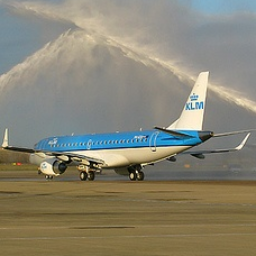

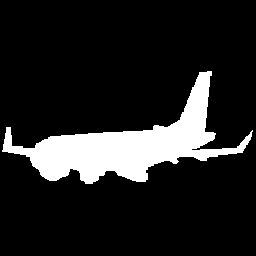

### plot of max Hausdorff symmetry for ../save/plane_car_1_PointRend__old/aeroplane-car-qualitative/obj/aeroplane_0200.obj

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0004052…

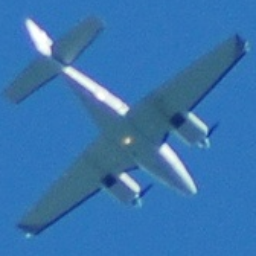

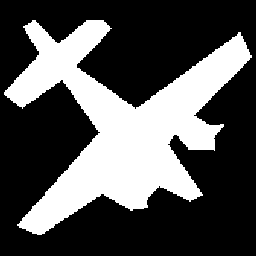

### ../save/plane_car_1_PointRend__old/aeroplane-car-qualitative/images/texture/0200.png

writing ../debug/image_table_0200.png
Plot saved to file plane_car_1_PointRend__old_aeroplane_Hsym_0099.html.


## Data from  ../save/plane_car_2_PointRend__old/aeroplane-car-qualitative/shape_symmetries.npy

(log file: ../save/plane_car_2_PointRend__old/aeroplane-car-qualitative/shape_symmetries.txt )
Reported errors :
    Max-Max Symmetry Errors  =  0.2717  for sample 0097
    Mean-Max Symmetry error = 0.13859639622080505
    Mean-Mean Symmetry error = 0.02048480094653865

    Mean Hausdorff  Symmetry error = 0.026586508398024386
    Max Hausdorff  Symmetry error =   0.0942 for sample 0063

Recompute errors after aligment (deviation=[-0.07300931 -3.02792218 -3.86877649]%) :
    Max Symmetry error  = 27.303% of shape width (on vertex 62 )
    Max Symmetry error  = 27.303% of shape width (on vertex 124 )
    Mesh with max error in the session:  ../save/plane_car_2_PointRend__old/aeroplane-car-qualitative/obj/aeroplane_0097.obj



### plot of max indes symmetry for ../save/plane_car_2_PointRend__old/aeroplane-car-qualitative/obj/aeroplane_0097.obj

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0011373…

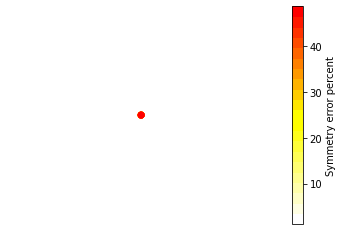

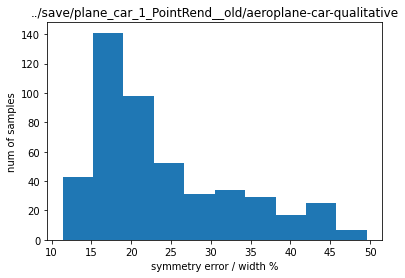

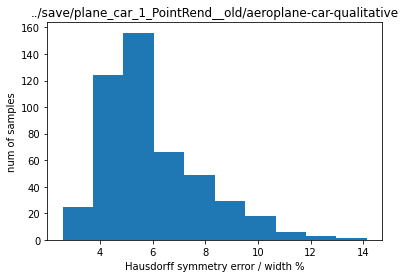

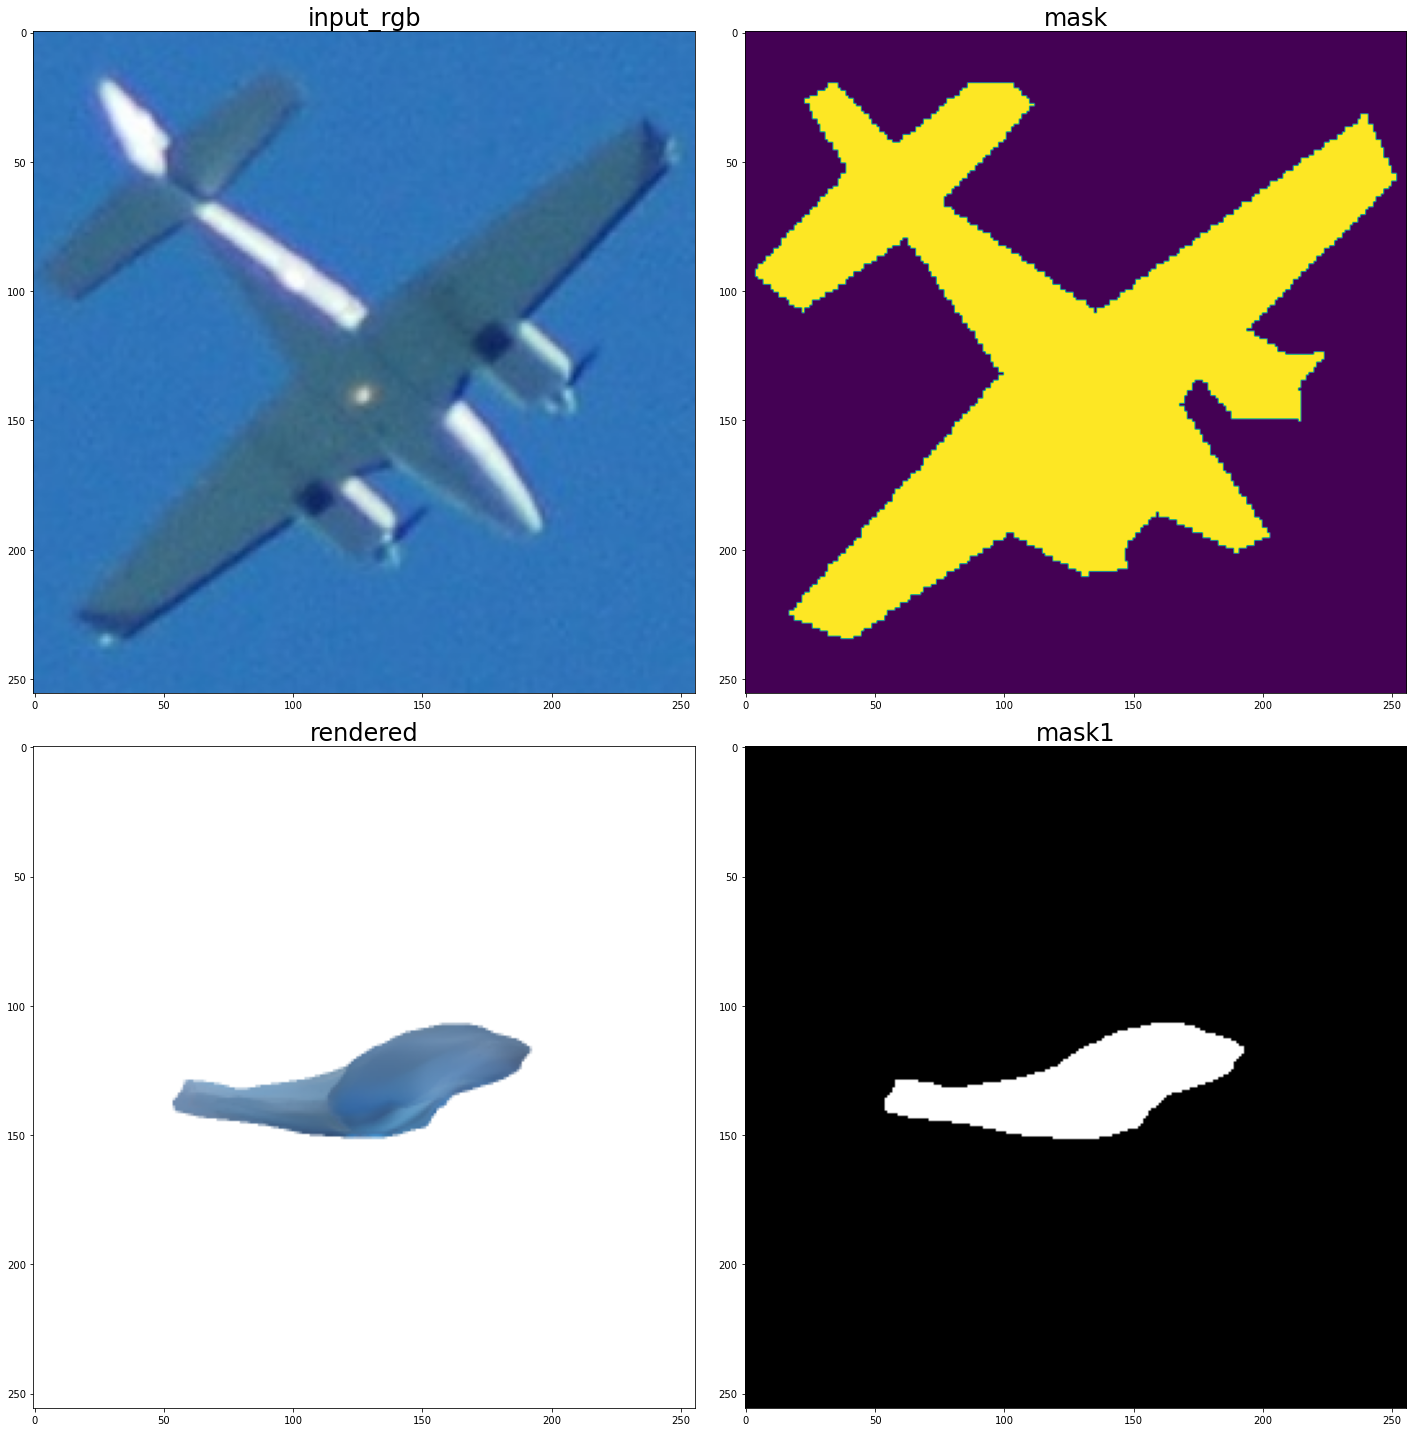

interactive(children=(Checkbox(value=True, description='show_sphere'), Output()), _dom_classes=('widget-intera…

Plot saved to file plane_car_2_PointRend__old_aeroplane_0097.html.
(477,)


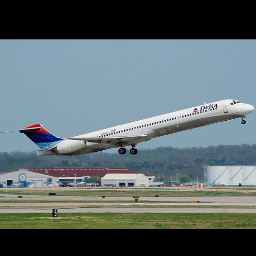

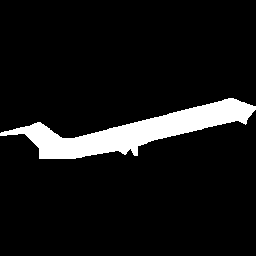

### plot of max Hausdorff symmetry for ../save/plane_car_2_PointRend__old/aeroplane-car-qualitative/obj/aeroplane_0063.obj

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.003741…

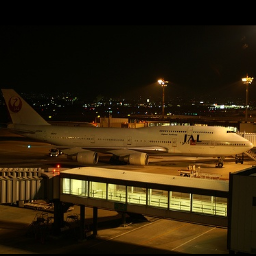

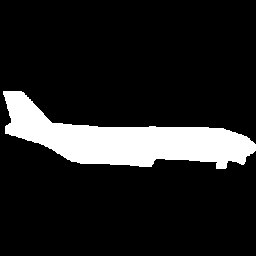

### ../save/plane_car_2_PointRend__old/aeroplane-car-qualitative/images/texture/0063.png

writing ../debug/image_table_0063.png
Plot saved to file plane_car_2_PointRend__old_aeroplane_Hsym_0097.html.


In [5]:
# with open(data_path + '/shape_symmetries.txt', 'r') as fd:
#     print(fd.read())
#     fd.close()

for data_path in data_path_list:
   display(Markdown(f'## Data from  {data_path}/shape_symmetries.npy'))
   print(f'(log file: {data_path}/shape_symmetries.txt )')


   #fetching saved data 
   data = np.load( data_path + '/shape_symmetries.npy', allow_pickle = True).item()
   LR_max = data['LR_max']
   V_right = data['V_right']
   V_opposite = data['V_opposite']
   H_symm = data['H_symm']
   i_max = LR_max.argmax()
   ih_max = H_symm.argmax()
   print(f'Reported errors :')
   print(f'    Max-Max Symmetry Errors  =  {LR_max.max():.4f}  for sample {i_max:04}')
   print(f'    Mean-Max Symmetry error = { data["LR_max"].sum()/data["LR_max"].shape[0]}')
   print(f'    Mean-Mean Symmetry error = { data["LR_mean"].sum()/data["LR_mean"].shape[0]}\n')

   print(f'    Mean Hausdorff  Symmetry error = { H_symm.sum()/H_symm.shape[0]}')
   print(f'    Max Hausdorff  Symmetry error =   {H_symm.max():.4f} for sample {ih_max:04}\n')


   # load mesh with max error
   class_name = os.path.split(data_path)[-1].split("-")[0]
   obj_file = f'{data_path}/obj/{class_name}_{i_max:04}.obj'
   V0, F = igl.read_triangle_mesh(obj_file)
   V = V0 -  np.mean(V0,axis=0) #align shape to 0,0,0  

   #recompute relative symmetry errors 
   LR_diff_unscaled = np.linalg.norm(V[V_right,:] - reflectX(V[V_opposite[V_right],:]), axis=1)
   shape_scale = V[:,0].max() - V[:,0].min()
   LR_diff = LR_diff_unscaled/shape_scale
   symm_error = np.zeros(V.shape[0])
   symm_error[V_right] = LR_diff
   symm_error[V_opposite[V_right]] = symm_error[V_right] 

   print(f'Recompute errors after aligment (deviation={100*np.mean(V0,axis=0)/shape_scale}%) :')
   print(f'    Max Symmetry error  = {100*LR_diff.max():.3f}% of shape width (on vertex {LR_diff.argmax()} )')
   print(f'    Max Symmetry error  = {100*symm_error.max():.3f}% of shape width (on vertex {symm_error.argmax()} )')
   print(f'    Mesh with max error in the session:  {obj_file}\n')

   #==== Indexed Deformation  Symmetry ====
   if enable_index_symmetry: 
      #error to color 
      bins =np.linspace(LR_diff.min(),LR_diff.max(),20)
      color1_np = np.linspace((1,1,1),(1,1,0),10)
      color2_np = np.linspace((1,1,0),(1,0,0),10+1)
      color_np = np.concatenate((color1_np,color2_np))
      symmetry_color = color_np[np.digitize(symm_error,bins),:]


      #pairs with max error for 
      vr_max= V_right[LR_diff.argmax()]
      vl_max= V_opposite[vr_max]
      Vh = np.stack( (V[vr_max,:],reflectX(V[vr_max,:]),V[vl_max,:]), axis =1 ).transpose()
      Ch = np.array([[0,0,1],[0,1,0],[0,0,1]])


      #mesh plot
      display(Markdown(f'### plot of max indes symmetry for {obj_file}'))
      p =mp.plot(V,F, c=  symmetry_color, shading = shading_dic)
      p.add_points( Vh, c = Ch, shading={"point_size": 0.15})
      #color =  LinearSegmentedColormap.from_list('symmetry_error',[(1,1,1),(1,0,0) ],20)

      #3D annotations (bbox, symmetry plane, max error pair)
      draw_bboxes(p, V)

      #draw the intial mean shape  
      sphere_id = [None] #put inside list to allow assign inside a function
      #visualize_sphere(p, V, [vr_max,vl_max], Ch[(0,2),:] )
      @mp.interact(show_sphere = show_sphere_bydefault)
      def draw_sphere_wrapper(show_sphere):
         if show_sphere:
            visualize_sphere(p, V, [vr_max,vl_max], Ch[(0,2),:]) 
         else:
            if sphere_plot_ids:
               for id in sphere_plot_ids:
                  p.remove_object(id)
            sphere_plot_ids.clear()

      if meshplot_to_html:
         base_name =  os.path.split(os.path.split(data_path)[0])[-1] 
         html_name = f'{base_name}_{class_name}_{i_max:04}.html'
         p.save(html_name)

      #colorbar plot
      color =  LinearSegmentedColormap.from_list('symmetry_error',color_np.tolist(),21)
      #plt.scatter(x=np.zeros(20), y=np.zeros(20), c=100*bins, cmap=color)
      #plt.colorbar(label="Symmetry error percent", orientation="vertical")
      f1, ax1 = plt.subplots()
      plt.axis('off')
      s = ax1.scatter(x=np.zeros(20), y=np.zeros(20), c=100*bins, cmap=color)
      f1.colorbar(s, label="Symmetry error percent", orientation="vertical", ax = ax1)

      f2, ax2 = plt.subplots()
      ax2.hist(100*LR_max)
      ax2.set_xlabel('symmetry error / width %')
      ax2.set_ylabel('num of samples')
      ax2.title.set_text(data_path)
      print(LR_max.shape)

      # Show inputs 
      rgb= Image(filename= f'{data_path}/input/{class_name}_rgb_{i_max:04}.png') 
      mask= Image(filename= f'{data_path}/input/{class_name}_mask_{i_max:04}.png') 
      display(rgb,mask)

   # ====  Hausdorff Shape Symmetry  ====
   if enable_Hausdorff_symmetry: 
      
      Hobj_file = f'{data_path}/obj/{class_name}_{ih_max:04}.obj'
      display(Markdown(f'### plot of max Hausdorff symmetry for {Hobj_file}'))

      ## mesh plot 
      VH0, FH = igl.read_triangle_mesh(Hobj_file)
      VH = VH0 -  np.mean(VH0,axis=0) #align shape to 0,0,0  
      VH_ref = reflectX(VH)
      sizeX = VH[:,0].max() - VH[:,0].min() 
      

      ph = mp.plot(VH ,FH,  shading = shading_dic)
      #mesh_obj= ph.add_mesh(VH + np.array([1.2*sizeX,0,0]) ,FH, shading = shading_dic)
      add_transparent_mesh(ph, VH + np.array([1.5*sizeX,0,0]) ,FH, c = color4plot([1,1,0],VH) , shading = shading_dic, opacity=0.5)
      add_transparent_mesh(ph, VH_ref + np.array([1.5*sizeX,0,0]), F, c = color4plot([0,0,1],VH) , shading = shading_dic, opacity=0.3)
      
      f3, ax3 = plt.subplots()
      ax3.hist(100*H_symm)
      ax3.title.set_text(data_path)
      ax3.set_xlabel('Hausdorff symmetry error / width %')
      ax3.set_ylabel('num of samples')

      # Show inputs 
      rgb= Image(filename= f'{data_path}/input/{class_name}_rgb_{ih_max:04}.png') 
      mask= Image(filename= f'{data_path}/input/{class_name}_mask_{ih_max:04}.png') 
      display(rgb,mask)
      
      if show_image_table:
         str = f'{ih_max:04}'
         class_name = os.path.split(data_path)[-1].split("-")[0]
         rend_image_file =  f'{data_path}/images/texture/{str}.png'
         Out(rend_image_file)
         rend_image = plt.imread(rend_image_file)
         rend_im_np = np.asarray(rend_image) 
         rend_im_mask = (rend_im_np !=  [1,1,1]).astype(float)
         #plt.imshow(rend_im_mask)
         image_table =  [ {'input_rgb': f'{data_path}/input/{class_name}_rgb_{str}.png', 'mask': f'{data_path}/input/{class_name}_mask_{str}.png'},
                 {'rendered': rend_image_file, 'mask1': rend_im_mask}
               ]
         du.picture_table_with_title(f'../debug/image_table_{str}.png', image_table, batch= None)

      if meshplot_to_html:
         base_name =  os.path.split(os.path.split(data_path)[0])[-1] 
         html_name = f'{base_name}_{class_name}_Hsym_{i_max:04}.html'
         p.save(html_name)



## Visual analysis of  reconstructed mesh vs  symmetrized mesh vs  its gt CAD mesh 
* symmetry errors of meshes 
* 3d metric errors between meshes and CAD 
* rgb mask inputs inputs 

In [53]:
def visualize_mesh_and_CAD_errors(data_path, V,F, Vsym, Vcad, Fcad):
   display(Markdown(f'## Data from  {data_path}/shape_symmetries.npy'))
   print(f'(log file: {data_path}/shape_symmetries.txt )')


   #fetching saved data 
   data = np.load( data_path + '/shape_symmetries.npy', allow_pickle = True).item()
   Out(f"data keys = { data.keys()}")
   #LR_max = data['LR_max']
   V_right = data['V_right']
   V_opposite = data['V_opposite']
   #H_symm = data['H_symm']
   #i_max = LR_max.argmax()
   #ih_max = H_symm.argmax()
   # print(f'Reported errors :')
   # print(f'    Max-Max Symmetry Errors  =  {LR_max.max():.4f}  for sample {i_max:04}')
   # print(f'    Mean-Max Symmetry error = { data["LR_max"].sum()/data["LR_max"].shape[0]}')
   # print(f'    Mean-Mean Symmetry error = { data["LR_mean"].sum()/data["LR_mean"].shape[0]}\n')

   # print(f'    Mean Hausdorff  Symmetry error = { H_symm.sum()/H_symm.shape[0]}')
   # print(f'    Max Hausdorff  Symmetry error =   {H_symm.max():.4f} for sample {ih_max:04}\n')


   # # load mesh with max error
   # class_name = os.path.split(data_path)[-1].split("-")[0]
   # obj_file = f'{data_path}/obj/{class_name}_{i_max:04}.obj'
   # V0, F = igl.read_triangle_mesh(obj_file)
   # V = V0 -  np.mean(V0,axis=0) #align shape to 0,0,0  

   #recompute relative symmetry errors 
   LR_diff_unscaled = np.linalg.norm(V[V_right,:] - gu.reflectX(V[V_opposite[V_right],:]), axis=1)
   shape_scale = V[:,0].max() - V[:,0].min()
   LR_diff = LR_diff_unscaled/shape_scale
   symm_error = np.zeros(V.shape[0])
   symm_error[V_right] = LR_diff
   symm_error[V_opposite[V_right]] = symm_error[V_right] 

   print(f'Recompute errors after aligment (deviation={100*np.mean(V0,axis=0)/shape_scale}%) :')
   print(f'    Max Symmetry error  = {100*LR_diff.max():.3f}% of shape width (on vertex {LR_diff.argmax()} )')
   print(f'    Max Symmetry error  = {100*symm_error.max():.3f}% of shape width (on vertex {symm_error.argmax()} )')
   #print(f'    Mesh with max error in the session:  {obj_file}\n')

   #==== Indexed Deformation  Symmetry ====
   if enable_index_symmetry: 
      #error to color 
      bins =np.linspace(LR_diff.min(),LR_diff.max(),20)
      color1_np = np.linspace((1,1,1),(1,1,0),10)
      color2_np = np.linspace((1,1,0),(1,0,0),10+1)
      color_np = np.concatenate((color1_np,color2_np))
      symmetry_color = color_np[np.digitize(symm_error,bins),:]


      #pairs with max error for 
      vr_max= V_right[LR_diff.argmax()]
      vl_max= V_opposite[vr_max]
      Vh = np.stack( (V[vr_max,:],gu.reflectX(V[vr_max,:]),V[vl_max,:]), axis =1 ).transpose()
      Ch = np.array([[0,0,1],[0,1,0],[0,0,1]])


      #mesh plot
      #display(Markdown(f'### plot of max indes symmetry for {obj_file}'))
      p =mp.plot(V,F, c=  symmetry_color, shading = shading_dic)
      p.add_points( Vh, c = Ch, shading={"point_size": 0.15})
      #color =  LinearSegmentedColormap.from_list('symmetry_error',[(1,1,1),(1,0,0) ],20)

      #3D annotations (bbox, symmetry plane, max error pair)
      draw_bboxes(p, V)

      #draw the intial mean shape  
      sphere_id = [None] #put inside list to allow assign inside a function
      #visualize_sphere(p, V, [vr_max,vl_max], Ch[(0,2),:] )
      @mp.interact(show_sphere = show_sphere_bydefault)
      def draw_sphere_wrapper(show_sphere):
         if show_sphere:
            visualize_sphere(p, V, [vr_max,vl_max], Ch[(0,2),:]) 
         else:
            if sphere_plot_ids:
               for id in sphere_plot_ids:
                  p.remove_object(id)
            sphere_plot_ids.clear()

      if meshplot_to_html:
         base_name =  os.path.split(os.path.split(data_path)[0])[-1] 
         html_name = f'{base_name}_mesh_cad_analysis.html'
         p.save(html_name)

      #colorbar plot
      color =  LinearSegmentedColormap.from_list('symmetry_error',color_np.tolist(),21)
      #plt.scatter(x=np.zeros(20), y=np.zeros(20), c=100*bins, cmap=color)
      #plt.colorbar(label="Symmetry error percent", orientation="vertical")
      f1, ax1 = plt.subplots()
      plt.axis('off')
      s = ax1.scatter(x=np.zeros(20), y=np.zeros(20), c=100*bins, cmap=color)
      f1.colorbar(s, label="Symmetry error percent", orientation="vertical", ax = ax1)

      f2, ax2 = plt.subplots()
      ax2.hist(100*LR_max)
      ax2.set_xlabel('symmetry error / width %')
      ax2.set_ylabel('num of samples')
      ax2.title.set_text(data_path)
      print(LR_max.shape)
   
   show_inputs = False
   enable_Hausdorff_symmetry = False

   if show_inputs:
      # Show inputs 
      rgb= Image(filename= f'{data_path}/input/{class_name}_rgb_{i_max:04}.png') 
      mask= Image(filename= f'{data_path}/input/{class_name}_mask_{i_max:04}.png') 
      display(rgb,mask)

   # ====  Hausdorff Shape Symmetry  ====
   if enable_Hausdorff_symmetry: 
      
      Hobj_file = f'{data_path}/obj/{class_name}_{ih_max:04}.obj'
      display(Markdown(f'### plot of max Hausdorff symmetry for {Hobj_file}'))

      ## mesh plot 
      VH0, FH = igl.read_triangle_mesh(Hobj_file)
      VH = VH0 -  np.mean(VH0,axis=0) #align shape to 0,0,0  
      VH_ref = reflectX(VH)
      sizeX = VH[:,0].max() - VH[:,0].min() 
      

      ph = mp.plot(VH ,FH,  shading = shading_dic)
      #mesh_obj= ph.add_mesh(VH + np.array([1.2*sizeX,0,0]) ,FH, shading = shading_dic)
      add_transparent_mesh(ph, VH + np.array([1.5*sizeX,0,0]) ,FH, c = color4plot([1,1,0],VH) , shading = shading_dic, opacity=0.5)
      add_transparent_mesh(ph, VH_ref + np.array([1.5*sizeX,0,0]), F, c = color4plot([0,0,1],VH) , shading = shading_dic, opacity=0.3)
      
      f3, ax3 = plt.subplots()
      ax3.hist(100*H_symm)
      ax3.title.set_text(data_path)
      ax3.set_xlabel('Hausdorff symmetry error / width %')
      ax3.set_ylabel('num of samples')

      # Show inputs 
      rgb= Image(filename= f'{data_path}/input/{class_name}_rgb_{ih_max:04}.png') 
      mask= Image(filename= f'{data_path}/input/{class_name}_mask_{ih_max:04}.png') 
      display(rgb,mask)
      
      if show_image_table:
         str = f'{ih_max:04}'
         class_name = os.path.split(data_path)[-1].split("-")[0]
         rend_image_file =  f'{data_path}/images/texture/{str}.png'
         Out(rend_image_file)
         rend_image = plt.imread(rend_image_file)
         rend_im_np = np.asarray(rend_image) 
         rend_im_mask = (rend_im_np !=  [1,1,1]).astype(float)
         #plt.imshow(rend_im_mask)
         image_table =  [ {'input_rgb': f'{data_path}/input/{class_name}_rgb_{str}.png', 'mask': f'{data_path}/input/{class_name}_mask_{str}.png'},
               {'rendered': rend_image_file, 'mask1': rend_im_mask}
               ]
         du.picture_table_with_title(f'../debug/image_table_{str}.png', image_table, batch= None)

      if meshplot_to_html:
         base_name =  os.path.split(os.path.split(data_path)[0])[-1] 
         html_name = f'{base_name}_{class_name}_Hsym_{i_max:04}.html'
         p.save(html_name)



# Analysing 3D metric results obtained from test preprocessing 

*  metric histograms 
*  best/worst outliners 
*  visualizng best worst cases 

In [3]:
class List(list):
    def __getitem__(self, keys):
        if isinstance(keys, (int, slice)): return list.__getitem__(self, keys)
        if isinstance(keys,np.ndarray):
            keys = keys.tolist()
        return [self[k] for k in keys]
        
def load_meshes_from_files(mesh_file_list):
    V_list=[]
    F_list=[]
    for mesh_file in mesh_file_list:
        V, F = igl.read_triangle_mesh(mesh_file)
        V_list.append(V)
        F_list.append(F)
    return V_list, F_list 

### test number 2, number of samples = (266, 4), number of meshes =266

###   best    symmetrization =  [0.32027955 0.2093542  0.03569797 0.02833369]

###       mean improvements = (array([-2.62162947,  3.26065361,  1.27073976,  1.15736447]), array([-2.69282168,  3.36969796,  0.94699418,  0.92033208])) %

100%|██████████| 13/13 [00:00<00:00, 14.99it/s]


writting ../debug/plots/plane_8_MRCNN__.aeroplane-qualitative.png
writting ../debug/plots/plane_8_MRCNN__.aeroplane-qualitative.png
writting ../debug/plots/plane_8_MRCNN__.aeroplane-qualitative.png
writting ../debug/plots/plane_8_MRCNN__.aeroplane-qualitative.png

 =================== Symmetrization Improvements per test (%) =====================
-------------------------------------  -------------------  ------------------  ------------------  ------------------
test                                   3d-iou               Hausdorf            max-mean            mean-mean
plane_8_MRCNN__.aeroplane-qualitative  -2.6928216841806245  3.3696979614831473  0.9469941763824103  0.9203320809870578
-------------------------------------  -------------------  ------------------  ------------------  ------------------


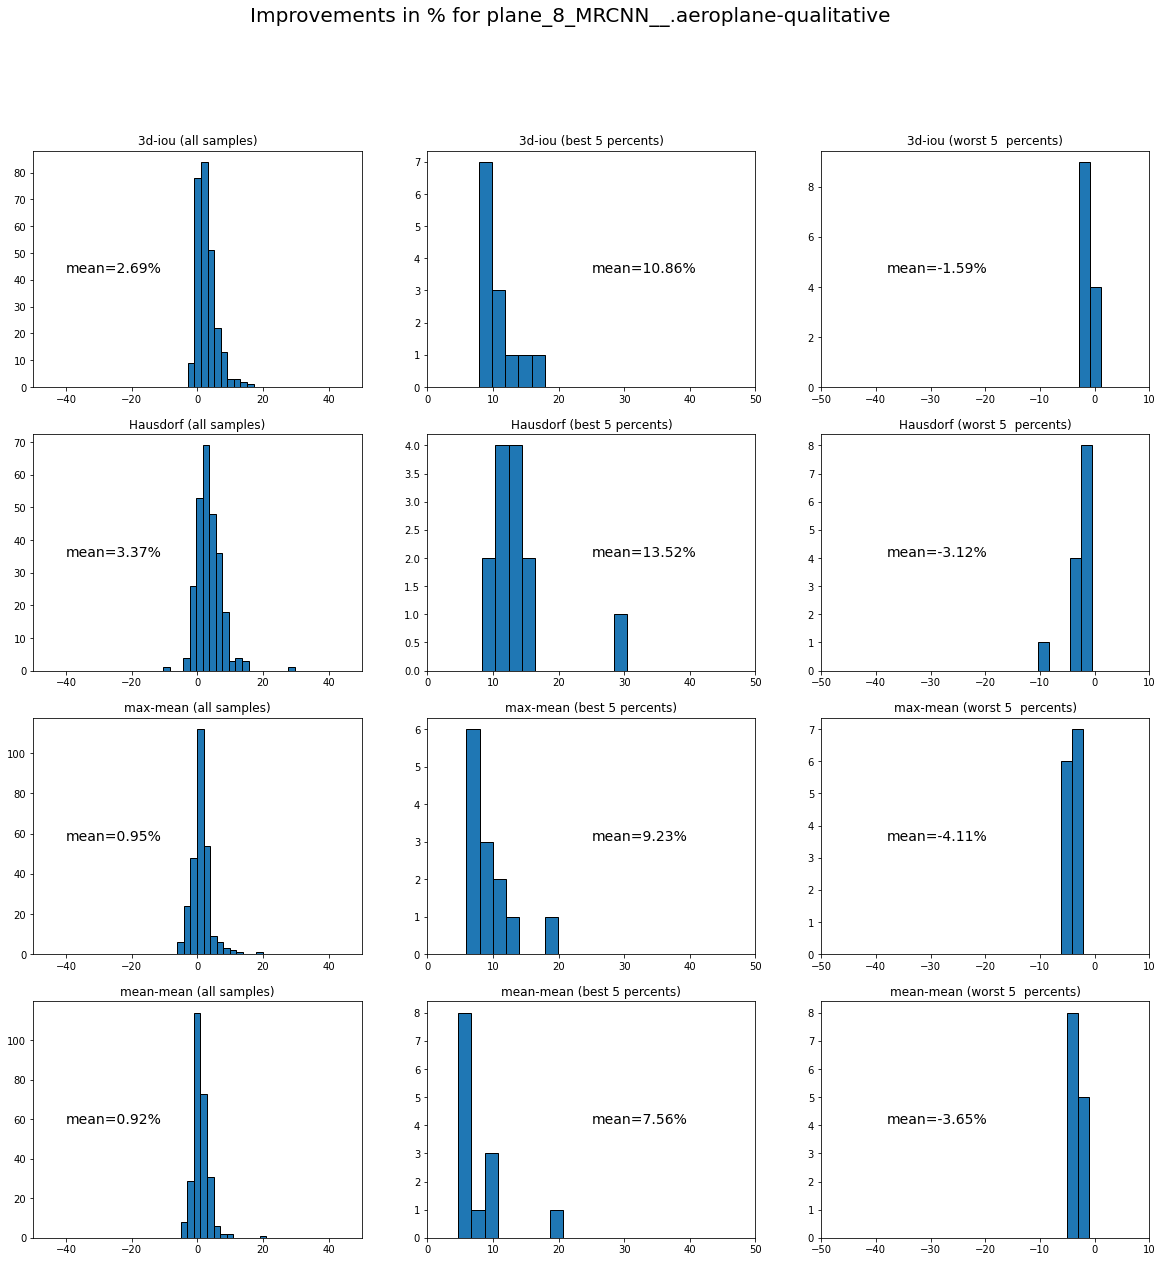

In [5]:
# main loop to get histograms and drawing 
import  utils.geometry as gu
from  auxilary.test_postprocessing import get_mesh_cad_file_pairs, SourceTargetMeshPipeline
shortenPath =  lambda path: '/'.join(path.split('/')[-3:-1]).replace('/', '.') #simple version of path to test name  
CAD_path   = "/home/ubuntu/research/datasets/Pascal3D+_release1.1/CAD_preprocessed_tri"
result_path_list = [ \
                    '../save/Pascal3D_12_classes_12_PointRend__/aeroplane-bicycle-boat-bottle-bus-car-chair-diningtable-motorbike-sofa-train-tvmonitor-qualitative', \
                    '../save/Pascal3D_12_classes_1_PointRend__/aeroplane-bicycle-boat-bottle-bus-car-chair-diningtable-motorbike-sofa-train-tvmonitor-qualitative', \
                    '../save/plane_8_MRCNN__/aeroplane-qualitative/', \
                    '../save/not_symmetric/car_10_MRCNN__/car-qualitative', \
                    '../save/plane_car_1_PointRend__/aeroplane-car-qualitative',\
                    '../save/plane_car_2_PointRend__/aeroplane-car-qualitative', \
                    '../save/bicycle_bus_car_bike_1_PointRend__/bicycle-bus-car-motorbike-qualitative',\
                    '../save/bicycle_bus_car_bike_4_PointRend__/bicycle-bus-car-motorbike-qualitative' \
                    ]   

test_name = [shortenPath(p) for p in result_path_list]
import pickle
resume_pkl= '../draft/estimatation_of_3D_metrics-full-100_voxel_without_rescaling.pkl'
with open(resume_pkl, 'rb') as handle:    experiment_data = pickle.load(handle)

# print(experiment_data.keys())
# print(experiment_data['reportSymmType'])
# print(experiment_data['reportSymm'])


reportOrig = experiment_data['reportOrig']
reportSymm = experiment_data['reportSymm']
metric_names = reportSymm.metric_names
reportImprovemetns = du.MetricReport(metric_names)

metric_num = len(reportSymm.metric_names)
#for ti in range(len(result_path_list)):
opt = gu.transformation_options(iter_num=10, sample_num = 2000, voxel_num =100,  enable_rescale = False, verbose =False)
opt.rewrite = False
for ti in [2]:
    mesh_files, cad_files = get_mesh_cad_file_pairs([result_path_list[ti]], CAD_path)
    metrics     = reportOrig.metrics_list[ti]
    metric_symm = reportSymm.metrics_list[ti]
    Out(f'test number {ti}, number of samples = {metric_symm.shape}, number of meshes ={len(mesh_files)}')
    Out(f"  best    symmetrization =  {metric_symm.mean(axis=0)}")


    
    mesh_files = List(mesh_files)
    cad_files  = List(cad_files)


    #metrics_mean = metrics.mean(axis=0).tolist()
    improvment =  100*(metrics - metric_symm ) / metrics
    metrics_mean = metrics.mean(axis=0).tolist()
    mean_improvment =  (metrics_mean - metric_symm.mean(axis=0)) / metrics_mean
    reportImprovemetns.add_test(test_name[ti], np.array(improvment))

    Out(f"      mean improvements = {(100*mean_improvment,improvment.mean(axis=0))} %")

    fig, axs = plt.subplots(metric_num, 3, figsize=(20,20) )
    fig.suptitle(f'Improvements in % for {test_name[ti]} ', fontsize=20)
    #for name in reportSymm.metric_names:
    sample_num = metrics.shape[0]
    V_meshes =[]
    F_meshes=[]
    Vsym_meshes =[]
    Vcad_meshes =[]
    Fcad_meshes =[]
    
    symmetry_data = np.load( result_path_list[ti] + '/shape_symmetries.npy', allow_pickle = True).item() #symmetry data is the same for all classes 


    for mi in range(len(reportSymm.metric_names)):
        name  =reportSymm.metric_names[mi]
        data = improvment[:,mi] if mi  else -improvment[:,mi] # 3D IoU goes in differnt direction
        Range = [-50, 50]

        w=2
        #histogram 
        axs[mi,0].hist(data, edgecolor='black', bins=np.arange(min(data), max(data) + w, w)) 
        axs[mi,0].title.set_text(f'{name} (all samples)')
        axs[mi,0].set_xlim(Range)
        axs[mi,0].text(0.1, 0.5, f'mean={data.mean():.2f}%', horizontalalignment='left',  verticalalignment='center', transform =  axs[mi,0].transAxes, fontsize=14)

        top_percent = 5
        top_num = int(top_percent/100*sample_num)
        
        worst_indices  = data.argsort()[:top_num]
        data_worst  =  data[ worst_indices ]

        best_indices = (-data).argsort()[:top_num]
        data_best =  data[best_indices]
        worst_mesh_files = mesh_files[worst_indices]
        worst_cad_files  = cad_files[worst_indices]
        #print( (worst_mesh_files, worst_cad_files) )

        if not V_meshes:

            _, F_meshes    = load_meshes_from_files(worst_mesh_files)
            Vcad_meshes, Fcad_meshes = load_meshes_from_files(worst_cad_files)
            
            metrics, V_meshes  = SourceTargetMeshPipeline( worst_mesh_files, worst_cad_files, \
                            [ (gu.align_open3d_PC_ICP, opt)], \
                            [ (gu.relative_symmetric_mesh_distances,) ]) 

            metrics_sym, Vsym_meshes  = SourceTargetMeshPipeline( worst_mesh_files, worst_cad_files, \
                            [ (gu.symmetrize_source_mesh, symmetry_data , True), (gu.align_open3d_PC_ICP, opt)], \
                            [ (gu.relative_symmetric_mesh_distances,) ]) 
        


       
        axs[mi,1].hist(data_best, edgecolor='black', bins=np.arange(min(data_best), max(data_best) + w, w)) 
        #axs[mi,1].hist(data_best10) 
        axs[mi,1].title.set_text(f'{name} (best {top_percent} percents)')
        #axs[mi,1].set_xlim( [.9*min(data_best10), .9*max(data_best10)])
        axs[mi,1].set_xlim([0,Range[1]])
        axs[mi,1].text(0.5, 0.5, f'mean={data_best.mean():.2f}%', horizontalalignment='left',  verticalalignment='center', transform =  axs[mi,1].transAxes, fontsize=14)

        axs[mi,2].hist(data_worst, edgecolor='black', bins=np.arange(min(data_worst), max(data_worst) + w, w)) 
        #axs[mi,2].hist(data_worst10) 
        axs[mi,2].title.set_text(f'{name} (worst {top_percent}  percents)')
        #axs[mi,2].set_xlim( [.9*min(data_worst10), .9*max(data_worst10)])
        axs[mi,2].set_xlim([Range[0], 10])
        axs[mi,2].text(0.2, 0.5, f'mean={data_worst.mean():.2f}%', horizontalalignment='left',  verticalalignment='center', transform =  axs[mi,2].transAxes, fontsize=14)
        fig_file = f'../debug/plots/{test_name[ti]}.png'
        fig.savefig(fig_file)
        print(f'writting {fig_file}')

report_orig_str   = reportImprovemetns.get_table("\n =================== Symmetrization Improvements per test (%) =====================")[0]


## Data from  ../save/plane_8_MRCNN__/aeroplane-qualitative//shape_symmetries.npy

(log file: ../save/plane_8_MRCNN__/aeroplane-qualitative//shape_symmetries.txt )


### data keys = dict_keys(['LR_mean', 'LR_max', 'V_right', 'V_opposite', 'cad_idx'])

Recompute errors after aligment (deviation=[-0.06274445 -2.60220663 -3.32483968]%) :
    Max Symmetry error  = 19.505% of shape width (on vertex 56 )
    Max Symmetry error  = 19.505% of shape width (on vertex 135 )


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0057446…

interactive(children=(Checkbox(value=True, description='show_sphere'), Output()), _dom_classes=('widget-intera…

Plot saved to file aeroplane-qualitative_mesh_cad_analysis.html.
(477,)


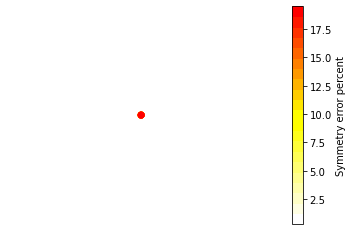

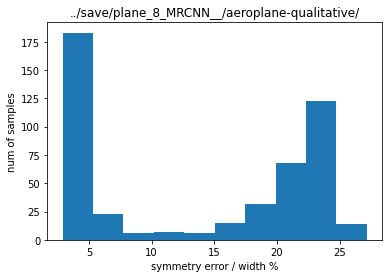

In [54]:
# print(data_path)
# data = np.load( data_path + '/shape_symmetries.npy', allow_pickle = True).item()
# print(data.keys())


# data = np.load('../save/plane_8_MRCNN__/aeroplane-qualitative' + '/shape_symmetries.npy', allow_pickle = True).item()
# print(data.keys())


visualize_mesh_and_CAD_errors('../save/plane_8_MRCNN__/aeroplane-qualitative/', V_meshes[0], F_meshes[0], Vsym_meshes[0], Vcad_meshes[0], Fcad_meshes[0])
